Para detectar a qualidade das ruas, usamos alguns parâmetros:
        
    -Acessibilidade;
    -Tráfego de carros;
    -Qualidade de deslocamento (Muitos buracos na rua, etc);
    -Saneamento e escoamento.

Para o primeiro processamento de imagem, estaremos analisando a acessibilidade que essa rua possui. Isso inclui: Calçada com suporte para deficientes visuais (piso tátil) e rampas para cadeirantes. A melhoria da acessibilidade vem também com a qualidade da rua, mas esse é um parâmetro que analisaremos mais adiante.

In [3]:
import numpy as np
import cv2

# Take the image and resize it to make it more readable for us
img = cv2.resize(cv2.imread('calcada-para-deficiente-visual.jpg', 0), (0, 0), fx=2, fy=2)

# Take te template we want to match to the image
template = cv2.resize(cv2.imread('Template.png', 0), (0, 0), fx=2, fy=2)

# Take the dimensions of the template image
h, w = template.shape

# Take a lot of methods to see wich one is more useful
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
            cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

# We pass for all the methods
for method in methods:
    img2 = img.copy()

    # Sliding our template throug our original image
    result = cv2.matchTemplate(img2, template, method)

    # Find the areas which the tamplate matches with the original image
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        location = min_loc
    else:
        location = max_loc

    bottom_right = (location[0] + w, location[1] + h) 

    # Create a rectangle in the area the program recognize a match   
    cv2.rectangle(img2, location, bottom_right, (255, 255, 0) , 2)
    cv2.imshow('Match', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [2]:
import numpy as np
import cv2

# Take the image and resize it to make it more readable for us
img = cv2.resize(cv2.imread('rampasdef.jpg', 0), (0, 0), fx=0.8, fy=0.8)

# Take te template we want to match to the image
template = cv2.resize(cv2.imread('Template2.png', 0), (0, 0), fx=0.8, fy=0.8)

# Take the dimensions of the template image
h, w = template.shape

# Take a lot of methods to see wich one is more useful
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
            cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

# We pass for all the methods
for method in methods:
    img2 = img.copy()

    # Sliding our template throug our original image
    result = cv2.matchTemplate(img2, template, method)

    # Find the areas which the tamplate matches with the original image
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        location = min_loc
    else:
        location = max_loc

    bottom_right = (location[0] + w, location[1] + h) 

    # Create a rectangle in the area the program recognize a match   
    cv2.rectangle(img2, location, bottom_right, (255, 255, 0) , 2)
    cv2.imshow('Match', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

O segundo ponto de análise para a qualidade das ruas é a quantidade de tráfego que ela possui todos os dias. Uma rua que engarrafa constantemente, por exemplo, a Alameda Boaventura, pode ser alvo de mais acidentes entre carros e pedestres e até entre carros e carros.

In [4]:
import cv2
import math


class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

# Create tracker object
tracker = EuclideanDistTracker()

cap = cv2.VideoCapture("highway.mp4")

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=120)

while True:
    ret, frame = cap.read()
    height, width, _ = frame.shape

    # Extract Region of interest
    roi = frame[340: 720,500: 800]

    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area > 100:
            #cv2.drawContours(roi, [cnt], -1, (0, 255, 0), 2)
            x, y, w, h = cv2.boundingRect(cnt)


            detections.append([x, y, w, h])

    # 2. Object Tracking
    boxes_ids = tracker.update(detections)
    for box_id in boxes_ids:
        x, y, w, h, id = box_id
        cv2.putText(roi, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)

    cv2.imshow("roi", roi)
    cv2.imshow("Frame", frame)
    cv2.imshow("Mask", mask)

    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

A facilidade em que andamos na rua também é um fator indispensável na qualidade dela. Saber se ela tem buracos, se é uma rua irregular ou uma rua lisa e perfeita para uma caminhada tem tudo a ver com a textura que ela apresenta, isso que irei explicar agora.

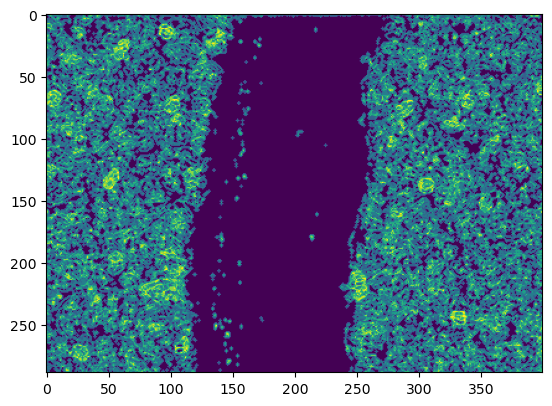

In [5]:
#This code apllies the entropy filter on an image:

import matplotlib.pyplot as plt
from skimage import io
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from skimage.filters import threshold_otsu
import cv2

img = cv2.imread("Teste.png")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

entropy_img = entropy(img_gray, disk(1))

cv2.imshow("Ruas", img)
key = cv2.waitKey(0)
cv2.destroyAllWindows
plt.imshow(entropy_img)

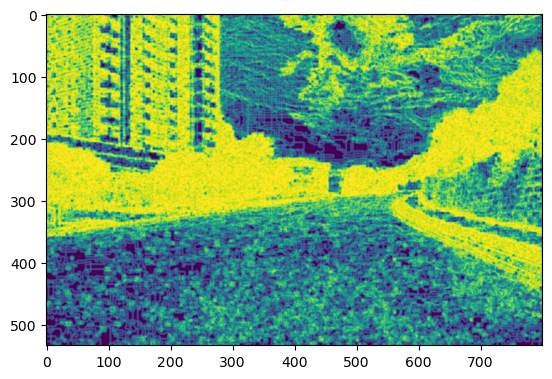

In [6]:
#This code apllies the entropy filter on an image:

import matplotlib.pyplot as plt
from skimage import io
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from skimage.filters import threshold_otsu
import cv2

img = cv2.imread("ruaboa.png")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

entropy_img = entropy(img_gray, disk(2))

cv2.imshow("Ruas", img)
key = cv2.waitKey(0)
cv2.destroyAllWindows

plt.imshow(entropy_img)

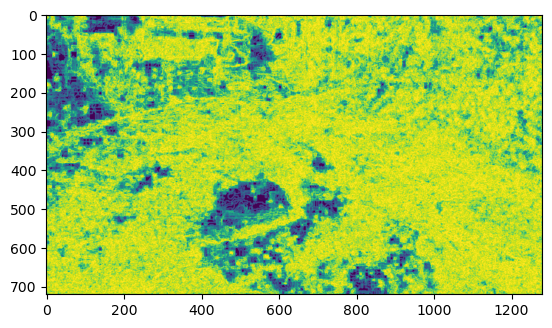

In [7]:
#This code apllies the entropy filter on an image:

import matplotlib.pyplot as plt
from skimage import io
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from skimage.filters import threshold_otsu
import cv2

img = cv2.imread("ruaesburacada3.jpg")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

entropy_img = entropy(img_gray, disk(2))

cv2.imshow("Ruas", img)
key = cv2.waitKey(0)
cv2.destroyAllWindows

plt.imshow(entropy_img)

C:\Users\gabri\AppData\Local\Temp\ipykernel_17768\3095146754.py:14: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_image = entropy(image_gray, disk(6))


-1

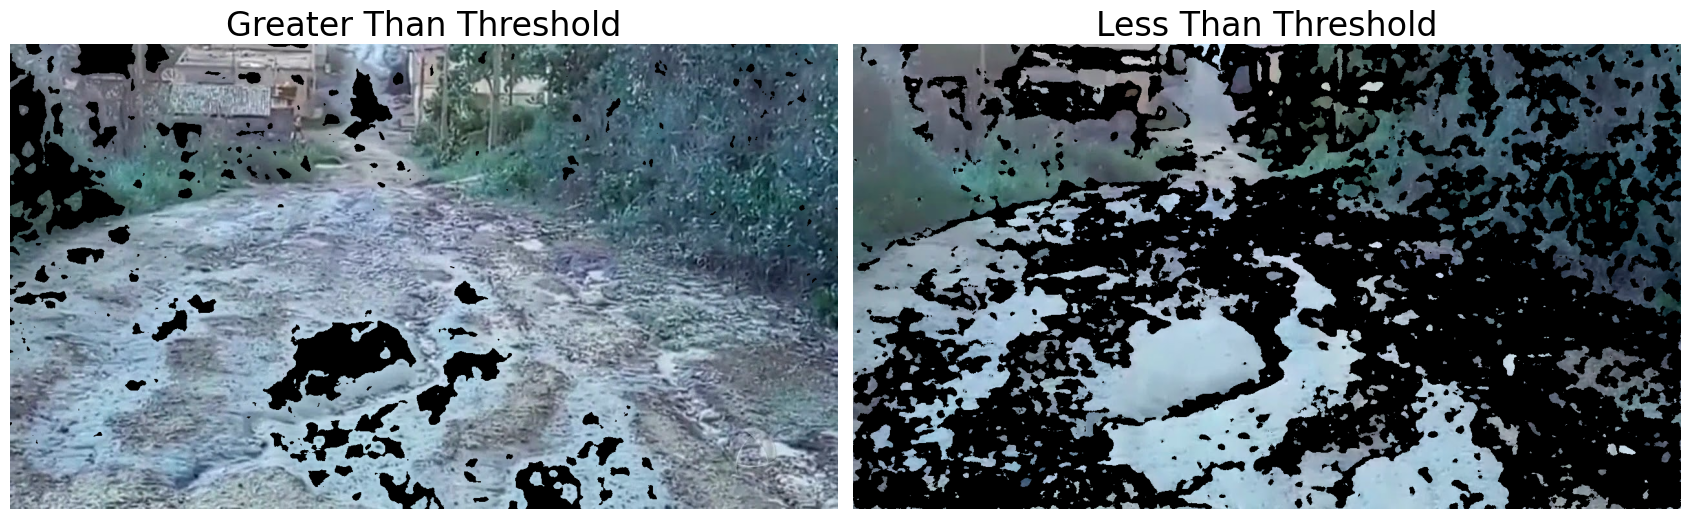

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
import cv2


def entropy_mask_viz(image):
    image_gray = rgb2gray(image)
    entropy_image = entropy(image_gray, disk(6))
    scaled_entropy = entropy_image / entropy_image.max()
    f_size = 24
    fig, ax = plt.subplots(1, 2, figsize=(17, 10))
    
    ax[0].set_title('Greater Than Threshold', 
                     fontsize = f_size)
    threshold = scaled_entropy > 0.5
    image_a = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[0].imshow(image_a)
    ax[0].axis('off')
    
    ax[1].set_title('Less Than Threshold', 
                     fontsize = f_size)
    threshold = scaled_entropy < 0.8
    image_b = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[1].imshow(image_b)
    ax[1].axis('off')
    fig.tight_layout()
    return [image_a, image_b]

img = cv2.imread("ruaesburacada3.jpg")
entropic_images = entropy_mask_viz(img)
cv2.imshow("Gray", img)
cv2.waitKey(0)

C:\Users\gabri\AppData\Local\Temp\ipykernel_17768\3095146754.py:14: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_image = entropy(image_gray, disk(6))


-1

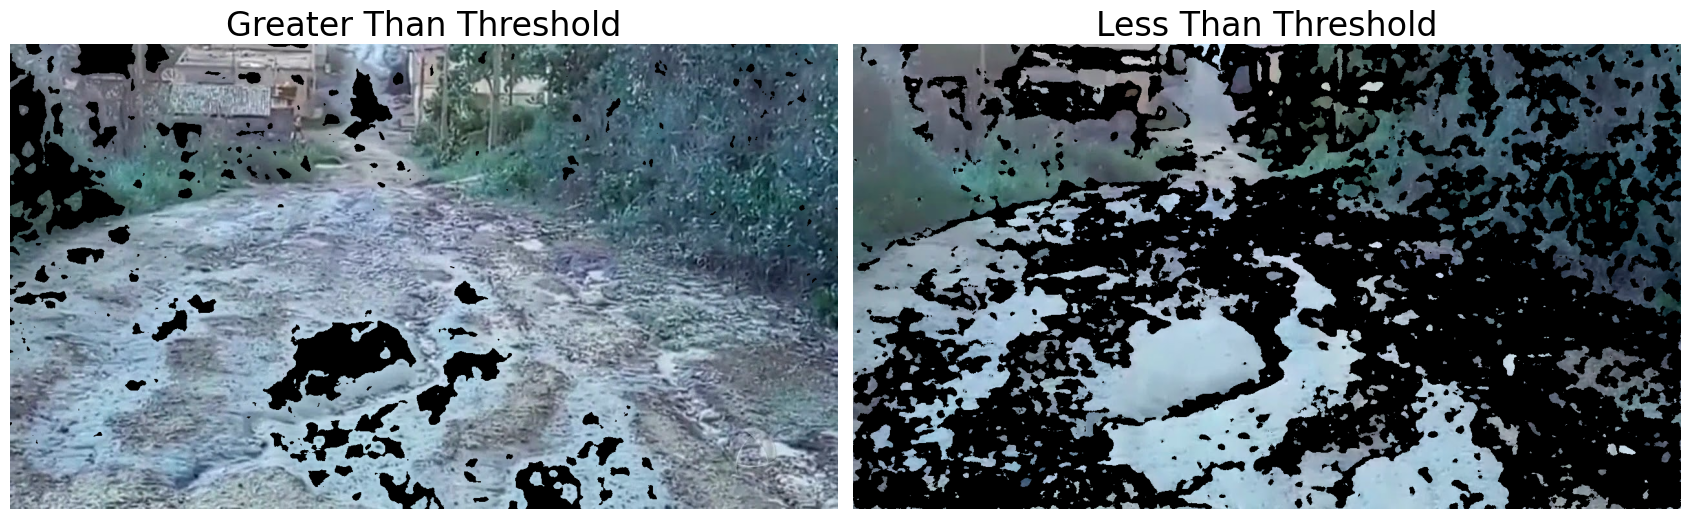

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
import cv2


def entropy_mask_viz(image):
    image_gray = rgb2gray(image)
    entropy_image = entropy(image_gray, disk(6))
    scaled_entropy = entropy_image / entropy_image.max()
    f_size = 24
    fig, ax = plt.subplots(1, 2, figsize=(17, 10))
    
    ax[0].set_title('Greater Than Threshold', 
                     fontsize = f_size)
    threshold = scaled_entropy > 0.5
    image_a = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[0].imshow(image_a)
    ax[0].axis('off')
    
    ax[1].set_title('Less Than Threshold', 
                     fontsize = f_size)
    threshold = scaled_entropy < 0.8
    image_b = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[1].imshow(image_b)
    ax[1].axis('off')
    fig.tight_layout()
    return [image_a, image_b]

img = cv2.imread("ruaesburacada3.jpg")
entropic_images = entropy_mask_viz(img)
cv2.imshow("Gray", img)
cv2.waitKey(0)

A partir de todos os dados mostrados, juntamente com a avaliação do usuário feita no aplicativo, um gráfico e uma média serão montados. Essa média determinará a qualidade da rua.